In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
!pip install pyspark

     |████████████████████████████████| 212.4MB 54kB/s 
     |████████████████████████████████| 204kB 17.9MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880768 sha256=3e6e0687048e41e7175622560c768c84f17c96318c92f3adfefc75782483bd84
  Stored in directory: /root/.cache/pip/wheels/40/1b/2c/30f43be2627857ab80062bef1527c0128f7b4070b6b2d02139
Successfully built pyspark


In [3]:
!ls

sample_data


In [4]:
!pwd

/content


# **Loading the dataset**

In [6]:
pdf = pd.read_csv('world-happiness-report.csv')
pdf.head(2)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.37,0.451,50.8,0.718,0.168,0.882,0.518,0.258
1,Afghanistan,2009,4.402,7.54,0.552,51.2,0.679,0.190,0.850,0.584,0.237


In [7]:
from pyspark import SparkContext
sc = SparkContext(appName='happiness-report')
sc

<SparkContext master=local[*] appName=happiness-report>

In [8]:
from pyspark.sql import SQLContext

sqlContext = SQLContext(sc)
sqlContext

In [9]:
import pyspark.sql.functions as F

In [10]:
#convert pandas dataframe into pyspark
sdf = sqlContext.createDataFrame(pdf)
sdf.show(5)

+------------+----+------------------+------------------+--------------+--------------------------------+----------------------------+-------------------+-------------------------+---------------+---------------+
|Country name|year|       Life Ladder|Log GDP per capita|Social support|Healthy life expectancy at birth|Freedom to make life choices|         Generosity|Perceptions of corruption|Positive affect|Negative affect|
+------------+----+------------------+------------------+--------------+--------------------------------+----------------------------+-------------------+-------------------------+---------------+---------------+
| Afghanistan|2008|3.7239999999999998|              7.37|         0.451|                            50.8|                       0.718|              0.168|                    0.882|          0.518|          0.258|
| Afghanistan|2009|             4.402|              7.54|         0.552|                            51.2|                       0.679|              

# **Filter**

In [16]:
latest_year = sdf.agg(F.max('year').alias('max_year'))
latest_year.show()

+--------+
|max_year|
+--------+
|    2020|
+--------+



In [17]:
type(latest_year)

pyspark.sql.dataframe.DataFrame

In [18]:
latest_year = latest_year.collect()
latest_year

[Row(max_year=2020)]

In [19]:
latest_year = latest_year[0]['max_year']
latest_year

2020

In [63]:
sdf_filtered = sdf.where("year = '{}'".format(latest_year))
sdf_filtered.show(10)

+--------------------+----+------------------+------------------+------------------+--------------------------------+----------------------------+--------------------+-------------------------+------------------+-------------------+
|        Country name|year|       Life Ladder|Log GDP per capita|    Social support|Healthy life expectancy at birth|Freedom to make life choices|          Generosity|Perceptions of corruption|   Positive affect|    Negative affect|
+--------------------+----+------------------+------------------+------------------+--------------------------------+----------------------------+--------------------+-------------------------+------------------+-------------------+
|             Albania|2020|             5.365|             9.497|              0.71|                            69.3|                       0.754|0.006999999999999999|       0.8909999999999999|             0.679|              0.265|
|           Argentina|2020|             5.901|              9.85|   

In [21]:
sdf_filtered.count()

95

# **Groupby and Aggregation**

In [33]:
overall_stats = sdf.agg(
    F.count("*").alias("number_of_records"), # to count the number of records in the dataset
    F.countDistinct("Country name").alias("number_of_countries"), # to get the distinct count of counties in column 'county'
)

overall_stats.show(1, False)

+-----------------+-------------------+
|number_of_records|number_of_countries|
+-----------------+-------------------+
|1949             |166                |
+-----------------+-------------------+



In [36]:
overall_stats_filtered = sdf_filtered.agg(
    F.count("*").alias("number_of_records"), # to count the number of records in the dataset
    F.countDistinct("Country name").alias("number_of_countries"), # to get the distinct count of counties in column 'countty'
)

overall_stats.show(1, False)

+-----------------+-------------------+
|number_of_records|number_of_countries|
+-----------------+-------------------+
|1949             |166                |
+-----------------+-------------------+



In [24]:
sdf_filtered.orderBy("Country Name").show(10, False)

+----------------------+----+------------------+------------------+------------------+--------------------------------+----------------------------+---------------------+-------------------------+------------------+-------------------+
|Country name          |year|Life Ladder       |Log GDP per capita|Social support    |Healthy life expectancy at birth|Freedom to make life choices|Generosity           |Perceptions of corruption|Positive affect   |Negative affect    |
+----------------------+----+------------------+------------------+------------------+--------------------------------+----------------------------+---------------------+-------------------------+------------------+-------------------+
|Albania               |2020|5.365             |9.497             |0.71              |69.3                            |0.754                       |0.006999999999999999 |0.8909999999999999       |0.679             |0.265              |
|Argentina             |2020|5.901             |9.85    

In [25]:
country_summary = sdf.groupBy(
    "Country name"
).agg(
    F.avg("Life Ladder").alias("life_ladder_avg"),
    F.avg("Log GDP per capita").alias("gdp_avg"),
    F.avg("Social Support").alias("social_support_avg"),
    F.count("*").alias("number_of_records"),
    F.countDistinct("Country name").alias("number_of_countries")
)

country_summary.orderBy("Country Name").show(20, False)

+----------------------+------------------+------------------+-------------------+-----------------+-------------------+
|Country name          |life_ladder_avg   |gdp_avg           |social_support_avg |number_of_records|number_of_countries|
+----------------------+------------------+------------------+-------------------+-----------------+-------------------+
|Afghanistan           |3.594666666666667 |7.650833333333334 |0.5084166666666666 |12               |1                  |
|Albania               |5.019384615384615 |9.384384615384615 |0.7162307692307692 |13               |1                  |
|Algeria               |5.389875          |9.328875000000002 |NaN                |8                |1                  |
|Angola                |4.420249999999999 |8.990000000000002 |0.73825            |4                |1                  |
|Argentina             |6.310133333333335 |10.033800000000001|0.9044000000000001 |15               |1                  |
|Armenia               |4.513571

In [26]:
from pyspark.sql.functions import col

avgColumns = [col('gdp_avg'), col('social_support_avg')]

averageFunc = sum(x for x in avgColumns)/len(avgColumns)

country_overall = country_summary.withColumn('Result(Avg)', averageFunc)
country_summary.withColumn('Result(Avg)', averageFunc).orderBy("Country Name").show(truncate=False)

+----------------------+------------------+------------------+-------------------+-----------------+-------------------+------------------+
|Country name          |life_ladder_avg   |gdp_avg           |social_support_avg |number_of_records|number_of_countries|Result(Avg)       |
+----------------------+------------------+------------------+-------------------+-----------------+-------------------+------------------+
|Afghanistan           |3.594666666666667 |7.650833333333334 |0.5084166666666666 |12               |1                  |4.079625          |
|Albania               |5.019384615384615 |9.384384615384615 |0.7162307692307692 |13               |1                  |5.050307692307692 |
|Algeria               |5.389875          |9.328875000000002 |NaN                |8                |1                  |NaN               |
|Angola                |4.420249999999999 |8.990000000000002 |0.73825            |4                |1                  |4.864125000000001 |
|Argentina          

# **Parition By & Window Function**

In [27]:
from pyspark.sql.window import Window

In [28]:
country_overall.show(2, False)

+------------+-----------------+-----------------+------------------+-----------------+-------------------+-----------------+
|Country name|life_ladder_avg  |gdp_avg          |social_support_avg|number_of_records|number_of_countries|Result(Avg)      |
+------------+-----------------+-----------------+------------------+-----------------+-------------------+-----------------+
|Albania     |5.019384615384615|9.384384615384615|0.7162307692307692|13               |1                  |5.050307692307692|
|North Cyprus|5.651571428571429|NaN              |0.8258571428571428|7                |1                  |NaN              |
+------------+-----------------+-----------------+------------------+-----------------+-------------------+-----------------+
only showing top 2 rows



In [29]:

country_summary_ranked = country_overall.withColumn(
    "life_rank", # column name
    F.rank().over(Window.orderBy("life_ladder_avg")) 
)

country_summary_ranked.show(5, False)

+------------------------+------------------+-----------------+------------------+-----------------+-------------------+------------------+---------+
|Country name            |life_ladder_avg   |gdp_avg          |social_support_avg|number_of_records|number_of_countries|Result(Avg)       |life_rank|
+------------------------+------------------+-----------------+------------------+-----------------+-------------------+------------------+---------+
|South Sudan             |3.402             |NaN              |0.55475           |4                |1                  |NaN               |1        |
|Central African Republic|3.5149999999999997|6.961            |0.4024            |5                |1                  |3.6817            |2        |
|Burundi                 |3.5482            |6.722399999999999|0.4178            |5                |1                  |3.570099999999999 |3        |
|Togo                    |3.555             |7.239222222222221|0.456             |9                |

In [30]:
country_summary_ranked = country_summary_ranked.withColumn(
    "life_rank_desc",
    F.rank().over(Window.orderBy(F.desc("life_ladder_avg")))
)

country_summary_ranked.orderBy("life_ladder_avg", ascending=False).show(5, False)

+------------+-----------------+------------------+------------------+-----------------+-------------------+------------------+---------+--------------+
|Country name|life_ladder_avg  |gdp_avg           |social_support_avg|number_of_records|number_of_countries|Result(Avg)       |life_rank|life_rank_desc|
+------------+-----------------+------------------+------------------+-----------------+-------------------+------------------+---------+--------------+
|Denmark     |7.6804           |10.879199999999999|0.9571333333333335|15               |1                  |5.918166666666666 |166      |1             |
|Finland     |7.597153846153845|10.749923076923075|0.949             |13               |1                  |5.849461538461537 |165      |2             |
|Switzerland |7.5483           |11.0954           |0.9436            |10               |1                  |6.0195            |164      |3             |
|Norway      |7.512400000000001|11.0391           |0.9504999999999999|10          

In [31]:
country_overall = country_overall.na.drop(subset=["Result(Avg)"])

country_summary_ranked = country_overall.withColumn(
    "Overall Rank",
    F.rank().over(Window.orderBy(F.desc("Result(Avg)")))
)

country_summary_ranked.orderBy("Result(Avg)", ascending=False).show(15, False)

+--------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------+
|Country name  |life_ladder_avg   |gdp_avg           |social_support_avg|number_of_records|number_of_countries|Result(Avg)       |Overall Rank|
+--------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------+
|Luxembourg    |7.0471818181818175|11.607090909090909|0.9204545454545454|11               |1                  |6.263772727272727 |1           |
|Singapore     |6.504230769230769 |11.328999999999999|0.8807692307692309|13               |1                  |6.104884615384615 |2           |
|Switzerland   |7.5483            |11.0954           |0.9436            |10               |1                  |6.0195            |3           |
|Ireland       |7.067714285714286 |11.064857142857145|0.9600000000000001|14               |1                  |6.012428571428573 |4     

ValueError: ignored

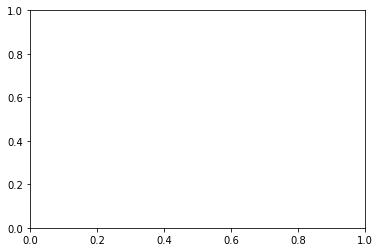

In [64]:
import matplotlib.pyplot as plt

y_ans_val = [val.Generosity for val in sdf.select('Generosity').filter(col("Country name") == "India")]
x_ts = [val.year for val in sdf.select('year').collect()]

plt.plot(x_ts, y_ans_val)

plt.ylabel('ans_val')
plt.xlabel('timestamp')
plt.title('ASN values for time')
plt.legend(['asn_val'], loc='upper left')

plt.show()